## Imports

In [1]:
import os
import sys
sys.path.insert(0, '../utils')
import transfer_utils 
import model_utils
import data_utils

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tqdm import tqdm
import numpy as np
import pandas as pd

import torchsummary
import torchvision
import torch
from transfer_model import NTLModel

import warnings
import logging
warnings.filterwarnings("ignore")
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

import wandb
wandb.init(project="tm-poverty-prediction")

use_gpu = "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device(use_gpu)
print("Using gpu: ", use_gpu)

%load_ext autoreload
%autoreload 2

wandb: Wandb version 0.8.27 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Using gpu:  cpu


## File Locations

In [2]:
# Google Cloud Storage
bucket_name = 'tm-geospatial'
dir = 'poverty-prediction-datasets'
image_dir = dir + '/images'

# Destination files
data_dir = '../data/zoom17/'
report_file = data_dir+'report.csv'
nightlights_unstacked_file = data_dir+'nightlights_unstacked.csv'

dhs_indicators_file = data_dir+'dhs_indicators.csv'
dhs_provinces_file = data_dir+'dhs_provinces.csv'
dhs_regions_file = data_dir+'dhs_regions.csv'

gsm_data_dir = data_dir+'images/' 
model_file = '../models/model_best.pt'
feature_embeddings_file = data_dir+'embeddingsv2.csv'
embeddings_indicators_file = data_dir+'indicators.csv'

# Test images for sanity checking purposes
high1_file = data_dir+'test_images/high1.jpg'
high2_file = data_dir+'test_images/high2.jpg'
low1_file = data_dir+'test_images/low1.jpg'
low2_file = data_dir+'test_images/low2.jpg'

## Load Datasets

In [3]:
report = pd.read_csv(report_file)
nightlights_unstacked = pd.read_csv(nightlights_unstacked_file)
dhs_indicators = pd.read_csv(dhs_indicators_file)
dhs_regions = pd.read_csv(dhs_regions_file)
dhs_provinces = pd.read_csv(dhs_provinces_file)

## Instantiate Transfer Model

In [4]:
# Load data
dataloaders, dataset_sizes, class_names = transfer_utils.load_transform_data(
    data_dir=gsm_data_dir, batch_size=4
)

# Instantiate model
model = torchvision.models.vgg16(pretrained=True)
model = NTLModel(model, len(class_names))
if use_gpu == "cuda":
    model = model.cuda()
    
# Load saved model
checkpoint = torch.load(model_file)
model.load_state_dict(checkpoint['state_dict'])

# Visualize model
torchsummary.summary(model, (3, 400, 400))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 400, 400]           1,792
              ReLU-2         [-1, 64, 400, 400]               0
            Conv2d-3         [-1, 64, 400, 400]          36,928
              ReLU-4         [-1, 64, 400, 400]               0
         MaxPool2d-5         [-1, 64, 200, 200]               0
            Conv2d-6        [-1, 128, 200, 200]          73,856
              ReLU-7        [-1, 128, 200, 200]               0
            Conv2d-8        [-1, 128, 200, 200]         147,584
              ReLU-9        [-1, 128, 200, 200]               0
        MaxPool2d-10        [-1, 128, 100, 100]               0
           Conv2d-11        [-1, 256, 100, 100]         295,168
             ReLU-12        [-1, 256, 100, 100]               0
           Conv2d-13        [-1, 256, 100, 100]         590,080
             ReLU-14        [-1, 256, 1

## Visualize Nighttime Light Intensity Classification Predictions

<Figure size 432x288 with 0 Axes>

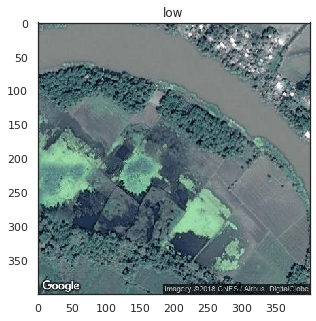

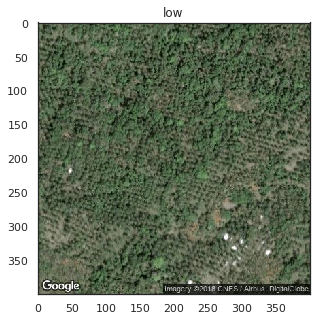

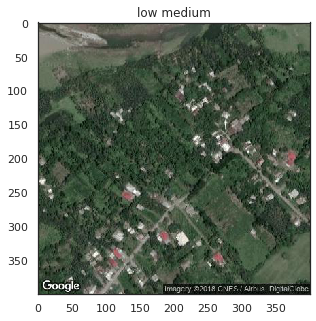

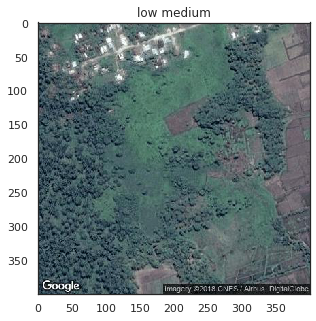

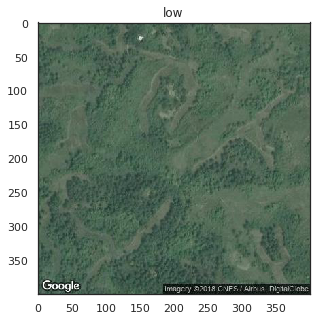

In [6]:
transfer_utils.visualize_model(model, dataloaders, class_names, 5, size=(5,5));

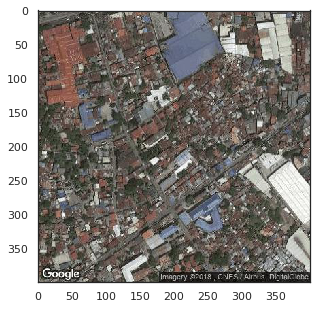

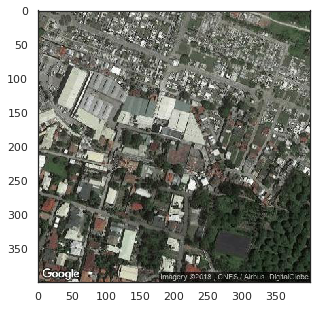

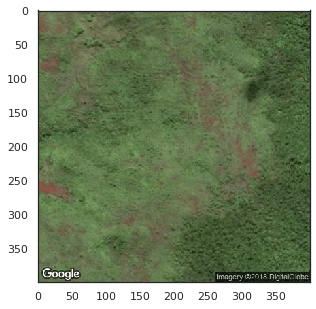

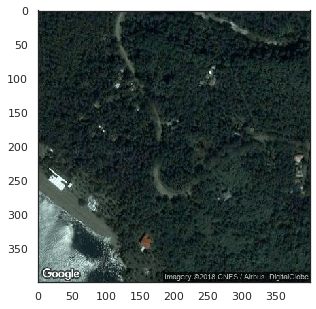

Embedding size: torch.Size([1, 4096])
Cosine similarity between 2 high nightlight intensity images: tensor([0.9794])
Cosine similarity between 2 low nightlight intensity images: tensor([0.9665])
Cosine similarity between 1 low and 1 high: tensor([0.5172])
Cosine similarity 1 high and 1 low: tensor([0.6518])


In [7]:
# Get feature embeddings for selected test images
high1_embedding = transfer_utils.get_embedding(high1_file, model, gpu=True)
high2_embedding = transfer_utils.get_embedding(high2_file, model, gpu=True)
low1_embedding = transfer_utils.get_embedding(low1_file, model, gpu=True)
low2_embedding = transfer_utils.get_embedding(low2_file, model, gpu=True)

# Display test images
figsize = (5,5)
plt.figure(figsize=figsize)
plt.imshow(mpimg.imread(high1_file))
plt.show()
plt.figure(figsize=figsize)
plt.imshow(mpimg.imread(high2_file))
plt.show()
plt.figure(figsize=figsize)
plt.imshow(mpimg.imread(low1_file))
plt.show()
plt.figure(figsize=figsize)
plt.imshow(mpimg.imread(low2_file))
plt.show()

# Sanity check: Get cosine similarity between feature embeddings
cos = torch.nn.CosineSimilarity(dim=1, eps=1e-6)
print("Embedding size: {}".format(high1_embedding.size()))
print('Cosine similarity between 2 high nightlight intensity images: {0}'.format(cos(high1_embedding,high2_embedding)))
print('Cosine similarity between 2 low nightlight intensity images: {0}'.format(cos(low1_embedding,low2_embedding)))
print('Cosine similarity between 1 low and 1 high: {0}'.format(cos(low1_embedding,high2_embedding)))
print('Cosine similarity 1 high and 1 low: {0}'.format(cos(high1_embedding,low2_embedding)))

## Generate feature embedding per cluster

In [ ]:
# Get feature embedding per image
report.filename = report.filename.str.replace('../../data/gsm_data/images/', '../data/images/')
report = nightlights_unstacked.merge(report, left_on='ID', right_on='id', how='left')
report = transfer_utils.get_embedding_per_image(report, model)
print("Report shape: {}".format(report.shape))

# Sanity check: Get feature embedding for 1 high light intensity image and 1 low intensity image
high = torch.from_numpy(np.array([report[report['label'] == 'high'].iloc[0]['embeddings']]))
low = torch.from_numpy(np.array([report[report['label'] == 'low'].iloc[5]['embeddings']]))

# Sanity Check: Cosine similarity between pairs of images
cos = torch.nn.CosineSimilarity(dim=1, eps=1e-6)
print("Cosine similarity is: {}".format(cos(low, high)))

In [9]:
# Get mean feature embedding per cluster
cluster_embeddings = transfer_utils.get_mean_embedding_per_cluster(report)

# Merge cluster embeddings with DHS indicators
cluster_embeddings = cluster_embeddings.merge(dhs_indicators, left_on='cluster', right_on='Cluster number')
feature_embeddings = cluster_embeddings.mean_embedding.apply(pd.Series)

# Save embeddings 
feature_embeddings.to_csv(feature_embeddings_file)
cluster_embeddings.to_csv(embeddings_indicators_file)

100%|██████████| 1214/1214 [00:02<00:00, 500.32it/s]


## Machine Learning Pipeline

In [4]:
scoring = {
    'r2': data_utils.pearsonr2,
    'rmse': data_utils.rmse
}

indicators = [
    'Wealth Index',
    'Education completed (years)',
    'Access to electricity',
    'Access to water (minutes)'
]

In [4]:
# Load embedding features
embeddings_df = pd.read_csv(feature_embeddings_file).iloc[:, 1:]
cluster_embeddings = pd.read_csv(embeddings_indicators_file)

region_cols = list(dhs_regions.columns[:-1])
province_cols = list(dhs_provinces.columns[:-1])
embedding_cols = list(embeddings_df.columns) 

# Merge with DHS indicators
embeddings_df['Cluster number'] = cluster_embeddings['Cluster number']
data = embeddings_df.merge(cluster_embeddings, on='Cluster number')

# Merge with regional and provincial indicators
data = data.merge(dhs_regions, on='Cluster number', how='left')
data = data.fillna(0)

print(data.shape)

(1213, 4123)


In [6]:
data[embedding_cols + ['Cluster number']].to_csv('dhs_embeddings.csv', index=False)

## t-SNE Visualization

In [28]:
embeddings = data.iloc[:, :4096]
feature_cols = embeddings.columns

embeddings['Cluster number'] = data['Cluster number']
embeddings['Wealth Index'] = data['Wealth Index']

# Sanity check embeddings
data.iloc[:, [-24, 0, 1, 2]].tail(3)

,mean_embedding,0,1,2
1210,[0.22440384 0.35943866 0.25587305 ... 0.778402...,0.224404,0.359439,0.255873
1211,[0.31538624 0.3674728 0.3414567 ... 0.979913...,0.315386,0.367473,0.341457
1212,[0.19449168 0.4283501 0.25667492 ... 0.861893...,0.194492,0.428350,0.256675


In [29]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(embeddings[feature_cols].values)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1213 samples in 0.126s...
[t-SNE] Computed neighbors for 1213 samples in 5.686s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1213
[t-SNE] Computed conditional probabilities for sample 1213 / 1213
[t-SNE] Mean sigma: 1.899533
[t-SNE] KL divergence after 250 iterations with early exaggeration: 58.150509
[t-SNE] KL divergence after 300 iterations: 0.717107


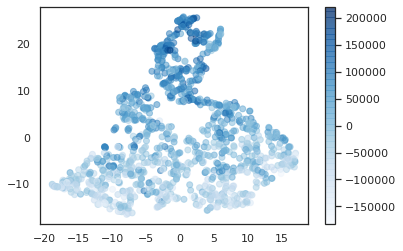

In [30]:
embeddings['x-tsne'] = tsne_results[:,0]
embeddings['y-tsne'] = tsne_results[:,1]

f, ax = plt.subplots()
points = ax.scatter(embeddings['x-tsne'], embeddings['y-tsne'], c=embeddings['Wealth Index'], cmap='Blues', alpha=0.5)
f.colorbar(points);

## Machine Learning Pipeline

### Using CNN feature embeddings + Regional indicators

Socioeconomic indicator: Wealth Index
fit_time : 1.8260
[2.21850228 1.71473527 1.71851158 1.72820234 1.75000405]
score_time : 0.0050
[0.00457573 0.00520587 0.00539613 0.00454235 0.00527191]
test_r2 : 0.6210
[0.66331803 0.58021426 0.62171203 0.6338985  0.60566736]
train_r2 : 0.7197
[0.70944439 0.7253901  0.72211575 0.71870938 0.7226454 ]
test_rmse : 43520.9720
[42114.74943898 41751.99753995 48224.78866134 42289.7190149
 43223.60518068]
train_rmse : 37692.2835
[38119.27209712 38170.30960824 36490.80324012 37910.05489202
 37770.97772107]


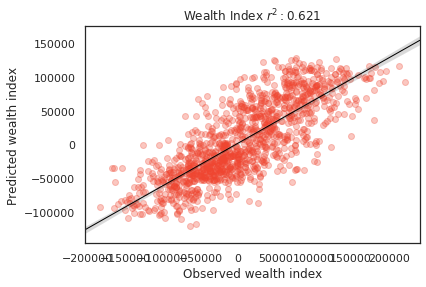

Best estimator: Pipeline(memory=None,
         steps=[('regressor',
                 Ridge(alpha=2.9279757672456204, copy_X=True,
                       fit_intercept=True, max_iter=None, normalize=False,
                       random_state=42, solver='auto', tol=0.001))],
         verbose=False)
Socioeconomic indicator: Education completed (years)
fit_time : 1.7519
[1.80005884 1.75668597 1.73543429 1.74404883 1.7230432 ]
score_time : 0.0052
[0.00535345 0.00520921 0.00547886 0.00524068 0.00458288]
test_r2 : 0.4679
[0.50479964 0.40441561 0.52122361 0.48694792 0.42224818]
train_r2 : 0.5991
[0.59143519 0.61003632 0.58350907 0.59877171 0.6116189 ]
test_rmse : 1.7087
[1.64003387 1.62337738 1.81683002 1.7239322  1.73938716]
train_rmse : 1.4935
[1.5117094  1.5136079  1.47536566 1.48632205 1.48073338]


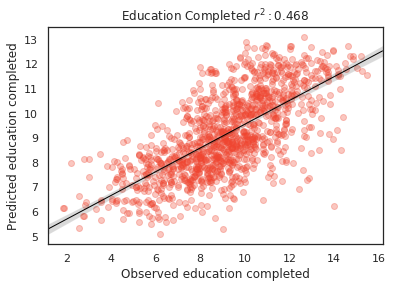

Best estimator: Pipeline(memory=None,
         steps=[('regressor',
                 Ridge(alpha=2.9279757672456204, copy_X=True,
                       fit_intercept=True, max_iter=None, normalize=False,
                       random_state=42, solver='auto', tol=0.001))],
         verbose=False)
Socioeconomic indicator: Access to electricity
fit_time : 1.7393
[1.74871898 1.72534108 1.72574759 1.73130846 1.76530504]
score_time : 0.0053
[0.00515223 0.00536895 0.00516701 0.00538135 0.00522542]
test_r2 : 0.2725
[0.26696974 0.2598997  0.35702992 0.282961   0.19550008]
train_r2 : 0.5132
[0.56339975 0.48036644 0.4607984  0.48092405 0.58056161]
test_rmse : 0.1231
[0.11896295 0.11717373 0.15374175 0.12381821 0.10174374]
train_rmse : 0.1023
[0.09894235 0.10767429 0.09810888 0.10584751 0.10115075]


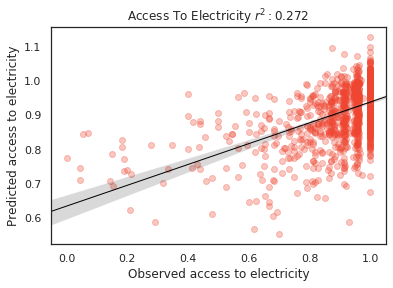

Best estimator: Pipeline(memory=None,
         steps=[('regressor',
                 Ridge(alpha=2.9279757672456204, copy_X=True,
                       fit_intercept=True, max_iter=None, normalize=False,
                       random_state=42, solver='auto', tol=0.001))],
         verbose=False)
Socioeconomic indicator: Access to water (minutes)
fit_time : 1.7545
[1.74363446 1.75445628 1.74250054 1.76671338 1.76532698]
score_time : 0.0053
[0.00534368 0.00543284 0.00542498 0.00522447 0.00528169]
test_r2 : 0.1005
[0.10563087 0.13804963 0.0554436  0.09243143 0.11098492]
train_r2 : 0.3358
[0.27933191 0.14328718 0.43585348 0.41842499 0.40192435]
test_rmse : 7.4361
[11.70308592  3.68295231  8.35474865  7.92995059  5.50967587]
train_rmse : 6.8417
[5.87382583 8.38141945 6.37893056 6.52711764 7.04715484]


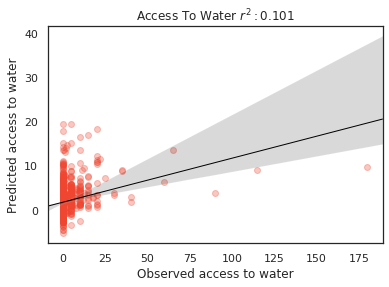

Best estimator: Pipeline(memory=None,
         steps=[('regressor',
                 Ridge(alpha=3.8028572256396647, copy_X=True,
                       fit_intercept=True, max_iter=None, normalize=False,
                       random_state=42, solver='auto', tol=0.001))],
         verbose=False)


In [31]:
predictions = model_utils.evaluate_model(
    data=data,
    feature_cols=embedding_cols+region_cols, 
    indicator_cols=indicators, 
    wandb=wandb,
    scoring=scoring,
    model_type='ridge', 
    refit='r2', 
    search_type='grid', 
    n_splits=5 ,
    n_workers=1
)

### Using CNN feature embeddings 

Socioeconomic indicator: Wealth Index
fit_time : 1.5779
[1.45340395 1.73421359 1.74516106 1.48373079 1.47296762]
score_time : 0.0042
[0.00415111 0.00411201 0.00416517 0.00405431 0.0043962 ]
test_r2 : 0.5871
[0.63680088 0.52880327 0.60478466 0.58990432 0.57508156]
train_r2 : 0.7209
[0.73428645 0.75479743 0.70471405 0.7052501  0.70524858]
test_rmse : 45439.2293
[43762.67198893 44539.99924296 49301.56784677 44736.66082506
 44855.24638342]
train_rmse : 37679.7566
[36623.54055851 36238.72762299 37687.61178292 38867.07413434
 38981.82889993]


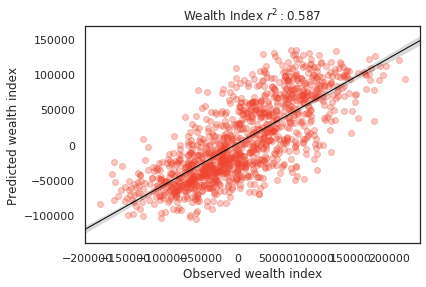

Best estimator: Pipeline(memory=None,
         steps=[('regressor',
                 Ridge(alpha=1.49816047538945, copy_X=True, fit_intercept=True,
                       max_iter=None, normalize=False, random_state=42,
                       solver='auto', tol=0.001))],
         verbose=False)
Socioeconomic indicator: Education completed (years)
fit_time : 1.6211
[1.73004889 1.72542143 1.72467637 1.45864558 1.46694994]
score_time : 0.0041
[0.00412679 0.00409865 0.00413656 0.00420165 0.00416684]
test_r2 : 0.4437
[0.48509955 0.37934656 0.49686329 0.46033564 0.39687287]
train_r2 : 0.5739
[0.57906806 0.58226574 0.55486129 0.57084296 0.58227655]
test_rmse : 1.7478
[1.67207662 1.65832338 1.86281611 1.77063719 1.77516263]
train_rmse : 1.5404
[1.53663425 1.5669436  1.52559057 1.53737643 1.53559597]


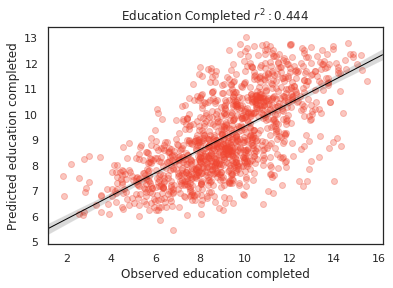

Best estimator: Pipeline(memory=None,
         steps=[('regressor',
                 Ridge(alpha=2.9279757672456204, copy_X=True,
                       fit_intercept=True, max_iter=None, normalize=False,
                       random_state=42, solver='auto', tol=0.001))],
         verbose=False)
Socioeconomic indicator: Access to electricity
fit_time : 1.4621
[1.44784904 1.45146823 1.44298744 1.47515917 1.49313569]
score_time : 0.0042
[0.00416875 0.00415516 0.00428057 0.00434327 0.00424075]
test_r2 : 0.2243
[0.20627583 0.21819061 0.25608713 0.26194545 0.17887573]
train_r2 : 0.4857
[0.51434349 0.41762766 0.44772023 0.51559013 0.53300973]
test_rmse : 0.1268
[0.12353077 0.11971375 0.16337046 0.12553201 0.1018315 ]
train_rmse : 0.1060
[0.10483783 0.11428559 0.09984418 0.10365681 0.10738055]


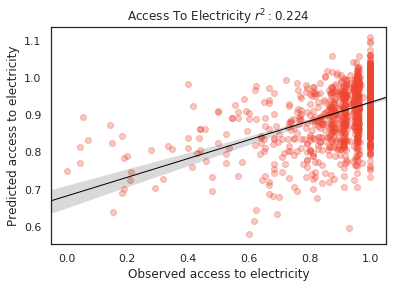

Best estimator: Pipeline(memory=None,
         steps=[('regressor',
                 Ridge(alpha=1.49816047538945, copy_X=True, fit_intercept=True,
                       max_iter=None, normalize=False, random_state=42,
                       solver='auto', tol=0.001))],
         verbose=False)
Socioeconomic indicator: Access to water (minutes)
fit_time : 1.4779
[1.47348857 1.46033335 1.44366765 1.49802184 1.51390266]
score_time : 0.0041
[0.00408697 0.00402522 0.00410151 0.00410056 0.00421166]
test_r2 : 0.0566
[0.04684892 0.10262928 0.041564   0.03858815 0.05320172]
train_r2 : 0.2841
[0.35103594 0.10069898 0.42477003 0.11392691 0.42988553]
test_rmse : 7.5781
[11.98941219  3.78652576  8.37480807  8.15919659  5.5805353 ]
train_rmse : 7.1237
[5.69452191 8.53699244 6.58435476 7.74401257 7.05882222]


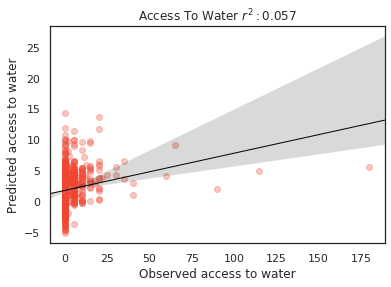

Best estimator: Pipeline(memory=None,
         steps=[('regressor',
                 Ridge(alpha=1.49816047538945, copy_X=True, fit_intercept=True,
                       max_iter=None, normalize=False, random_state=42,
                       solver='auto', tol=0.001))],
         verbose=False)


In [33]:
predictions = model_utils.evaluate_model(
    data=data,
    wandb=None,
    feature_cols=embedding_cols, 
    indicator_cols=indicators, 
    scoring=scoring,
    model_type='ridge', 
    refit='r2', 
    search_type='grid', 
    n_splits=5,
    n_workers=1
)